In [1]:
#Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Load datasets
games = pd.read_csv('games.csv')
games_details = pd.read_csv('games_details.csv', low_memory=False)
players = pd.read_csv('players.csv')
ranking= pd.read_csv('ranking.csv')
teams = pd.read_csv('teams.csv')


In [4]:

# Display basic information about each dataset
print("Games Dataset:")
print(games.info())
print("\nGames Details Dataset:")
print(games_details.info())
print("\nPlayers Dataset:")
print(players.info())
print("\nRanking Dataset:")
print(ranking.info())
print("\nTeams Dataset:")
print(teams.info())

Games Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float64
 9   FT_PCT_home       26552 non-null  float64
 10  FG3_PCT_home      26552 non-null  float64
 11  AST_home          26552 non-null  float64
 12  REB_home          26552 non-null  float64
 13  TEAM_ID_away      26651 non-null  int64  
 14  PTS_away          26552 non-null  float64
 15  FG_PCT_away       26552 non-null  float64
 16  FT_PCT_away       26552 n

# Win comparision Home and Away games

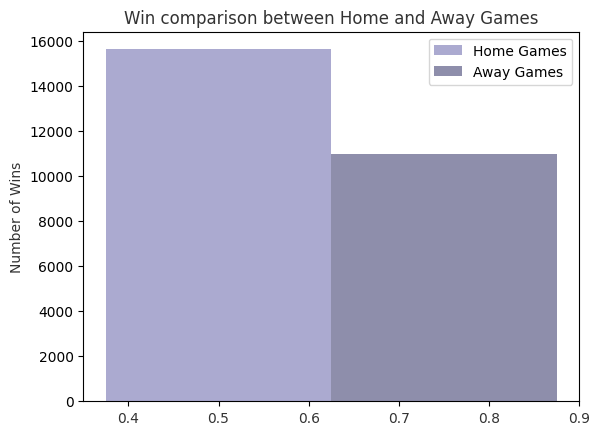

In [5]:
#Win comparision Home and Away games
import numpy as np
import matplotlib.pyplot as plt

wl_group = games.groupby(['HOME_TEAM_WINS'])

win_filt = wl_group.get_group(1)
lose_filt = wl_group.get_group(0)


x = win_filt['HOME_TEAM_WINS'].value_counts()
y = lose_filt['HOME_TEAM_WINS'].value_counts()

ti = [0.5]
hor = np.arange(len(ti))


plt.bar(ti, x, width=0.25, color='#ABAAD0', label='Home Games')  # White
plt.bar(hor + 0.75, y, width=0.25, color='#8E8EAB', label='Away Games')  # Light Gray

plt.ylabel('Number of Wins', color='#333333')  # Dark grey for text
plt.xticks(color='#333333')  # Dark grey for ticks
plt.title('Win comparison between Home and Away Games', color='#333333')  # Dark grey for title
plt.legend()

plt.show()

# Clutch performace Analysis:


<ipython-input-6-2b20efb1e472>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_details_subset.dropna(inplace=True)


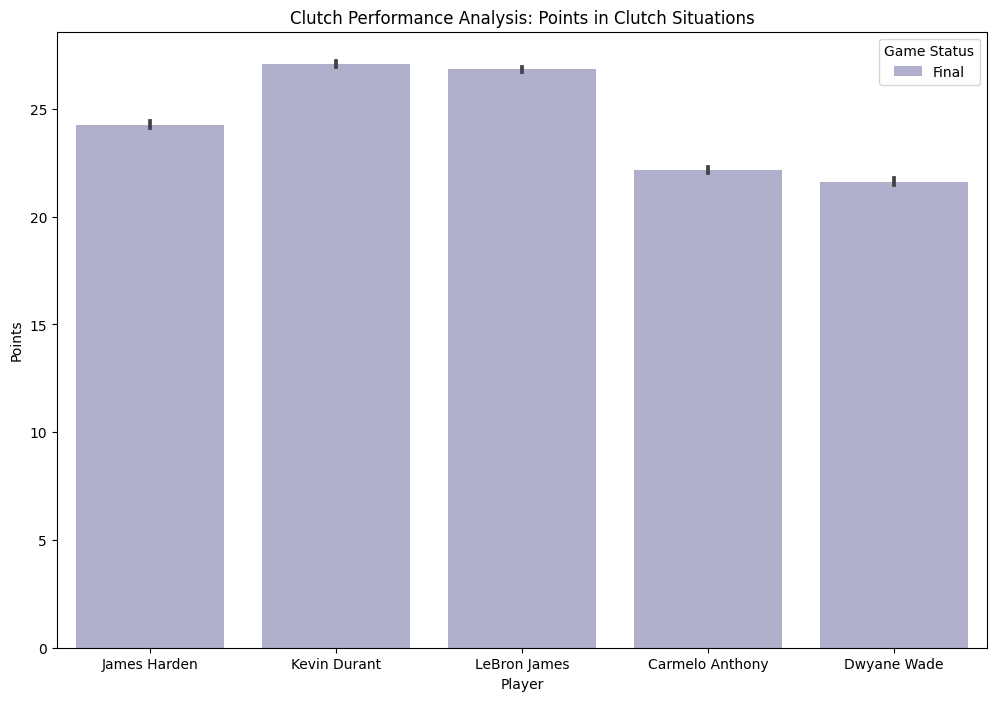

In [6]:
# Example criteria for clutch situations: games with a score difference of 5 points or less in the last 5 minutes
clutch_games = games[(abs(games['PTS_home'] - games['PTS_away']) <= 5) & (games['GAME_STATUS_TEXT'] == 'Final')]
clutch_game_ids = clutch_games['GAME_ID'].unique()


required_columns_details = ['GAME_ID', 'PLAYER_ID', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'MIN']
games_details_subset = games_details[required_columns_details]

# Handling missing values in each dataset
games.dropna(inplace=True)
players.dropna(inplace=True)
games_details_subset.dropna(inplace=True)


merged_data = pd.merge(games, games_details_subset, left_on='GAME_ID', right_on='GAME_ID')
merged_data = pd.merge(merged_data, players, left_on='PLAYER_ID', right_on='PLAYER_ID')


clutch_players = merged_data.groupby('PLAYER_NAME')['PTS'].sum().nlargest(5).index


clutch_players_data = merged_data[merged_data['PLAYER_NAME'].isin(clutch_players)]

# Using complementary shades for the bar plot
sns.set_palette(sns.color_palette(['#ABAAD0', '#C9C9DC']))

# Visualizing clutch performance metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=clutch_players_data, x='PLAYER_NAME', y='PTS', hue='GAME_STATUS_TEXT')
plt.xlabel('Player')
plt.ylabel('Points')
plt.title('Clutch Performance Analysis: Points in Clutch Situations')
plt.legend(title='Game Status')
plt.show()

In [7]:
# Merging games and games_details datasets

# Selecting subset of required columns from games_details
required_columns = ['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'MIN', 'FGM', 'FTM', 'TO', 'PTS', 'REB', 'AST', 'STL', 'BLK']
games_details_subset = games_details[required_columns]

# Handling missing values in each dataset
games.dropna(inplace=True)
games_details_subset.dropna(inplace=True)
players.dropna(inplace=True)

# Merging datasets based on common columns
merged_data = pd.merge(games, games_details_subset, left_on='GAME_ID', right_on='GAME_ID')
merged_data = pd.merge(merged_data, players, left_on='PLAYER_ID', right_on='PLAYER_ID')

<ipython-input-7-da603177c4cf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_details_subset.dropna(inplace=True)


# Calculating Player Efficiency Rating

In [8]:
# Converting 'MIN' column to numeric values
merged_data['MIN'] = pd.to_numeric(merged_data['MIN'], errors='coerce')

# Dropping rows where 'MIN' is NaN
merged_data = merged_data.dropna(subset=['MIN'])

# Calculating PER for each player
merged_data['PER'] = (
    (merged_data['PTS'] + merged_data['REB'] + merged_data['AST'] + merged_data['STL'] + merged_data['BLK']
     - merged_data['FGM'] - merged_data['FTM'] - merged_data['TO'])
    / merged_data['MIN']
) * 48  # Per-minute multiplier

# Grouping by player, team, and season to analyze PER across teams and seasons
per_analysis = merged_data.groupby(['PLAYER_NAME', 'TEAM_ID_home', 'SEASON_x'])['PER'].mean().reset_index()

# Identify the most efficient players
most_efficient_players = per_analysis.loc[per_analysis.groupby(['SEASON_x', 'TEAM_ID_home'])['PER'].idxmax()]

# Displaying the results
print("Player Efficiency Ratings (PER) Analysis:")
print(most_efficient_players)

Player Efficiency Ratings (PER) Analysis:
            PLAYER_NAME  TEAM_ID_home  SEASON_x         PER
3053       Darius Miles    1610612737      2003  192.000000
1193        Ben Wallace    1610612738      2003  172.800000
3941        Drew Gooden    1610612740      2003  201.600000
12138        Steve Nash    1610612742      2003  163.200000
4027        Dwyane Wade    1610612748      2003  240.000000
...                 ...           ...       ...         ...
3305     DeAndre Jordan    1610612762      2013   39.272727
4020      Dwight Howard    1610612763      2013   41.600000
7451      Kevin Garnett    1610612764      2013   40.000000
7144    Justin Hamilton    1610612765      2013   42.666667
10126  Patrick O'Bryant    1610612766      2013   64.000000

[311 rows x 4 columns]


<ipython-input-8-99ce32e30263>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['PER'] = (


In [9]:
# Finding the index of the maximum PER for each unique year and team combination
max_per_index = merged_data.groupby(['SEASON_x', 'TEAM_ID_home'])['PER'].idxmax()


highest_per_players = merged_data.loc[max_per_index]

# Droping duplicate years, keeping only the player with the maximum total points and total rebounds in case of ties
highest_per_players = highest_per_players.sort_values(by=['SEASON_x', 'TEAM_ID_home', 'PTS', 'REB'], ascending=[True, True, False, False])
highest_per_players = highest_per_players.drop_duplicates(subset=['SEASON_x', 'TEAM_ID_home'])

print("Highest PER Player for Each Year:")
print(highest_per_players[['SEASON_x', 'TEAM_ID_home', 'PLAYER_NAME', 'PER', 'PTS', 'REB']])

# Sorting the DataFrame by 'PER' within each season and then by 'SEASON_x'
sorted_highest_per_players = highest_per_players.sort_values(by=['SEASON_x', 'PER'], ascending=[True, False])

# Displaying the sorted DataFrame
print("Sorted DataFrame:")
print(sorted_highest_per_players[['SEASON_x', 'TEAM_ID_home', 'PLAYER_NAME', 'PER', 'PTS', 'REB']])

Highest PER Player for Each Year:
         SEASON_x  TEAM_ID_home       PLAYER_NAME         PER   PTS   REB
3561750      2003    1610612737      Darius Miles  192.000000  13.0   7.0
3479369      2003    1610612738       Ben Wallace  172.800000  17.0   6.0
2133719      2003    1610612740       Drew Gooden  201.600000  29.0   5.0
3027833      2003    1610612742        Steve Nash  163.200000  12.0   2.0
1908239      2003    1610612748       Dwyane Wade  240.000000  18.0   8.0
...           ...           ...               ...         ...   ...   ...
1060693      2013    1610612762    Derrick Favors   40.320000  10.0  14.0
1270357      2013    1610612763     Dwight Howard   41.600000   6.0  10.0
3265422      2013    1610612764    Josh Childress   64.000000   3.0   1.0
2831569      2013    1610612765   Justin Hamilton   42.666667   8.0   4.0
3288030      2013    1610612766  Patrick O'Bryant   64.000000   2.0   5.0

[311 rows x 6 columns]
Sorted DataFrame:
         SEASON_x  TEAM_ID_home     

In [10]:

sorted_highest_per_players = sorted_highest_per_players.replace([np.inf, -np.inf], np.nan).dropna(subset=['PER'])

# Selecting only one player per SEASON_x (the first value)
subset_highest_per_players = sorted_highest_per_players.groupby('SEASON_x').first().reset_index()

print("Subset of Highest PER Players:")
print(subset_highest_per_players[['SEASON_x', 'TEAM_ID_home', 'PLAYER_NAME', 'PER', 'PTS', 'REB']])



Subset of Highest PER Players:
    SEASON_x  TEAM_ID_home    PLAYER_NAME         PER   PTS   REB
0       2003    1610612748    Dwyane Wade  240.000000  18.0   8.0
1       2004    1610612757  Zach Randolph  268.800000  13.0  16.0
2       2005    1610612765   Dwayne Jones   72.000000   0.0   2.0
3       2006    1610612763  Vincent Grier  112.000000   2.0   4.0
4       2007    1610612761      Luol Deng   72.000000   2.0   0.0
5       2008    1610612748  Ryan Anderson  384.000000   9.0   9.0
6       2009    1610612753    Will Conroy  120.000000   4.0   1.0
7       2010    1610612743  Al Harrington   96.000000   0.0   1.0
8       2011    1610612750     Kevin Love   53.333333  21.0  15.0
9       2012    1610612739     Beno Udrih   96.000000   3.0   0.0
10      2013    1610612747  Trent Lockett   96.000000   2.0   2.0


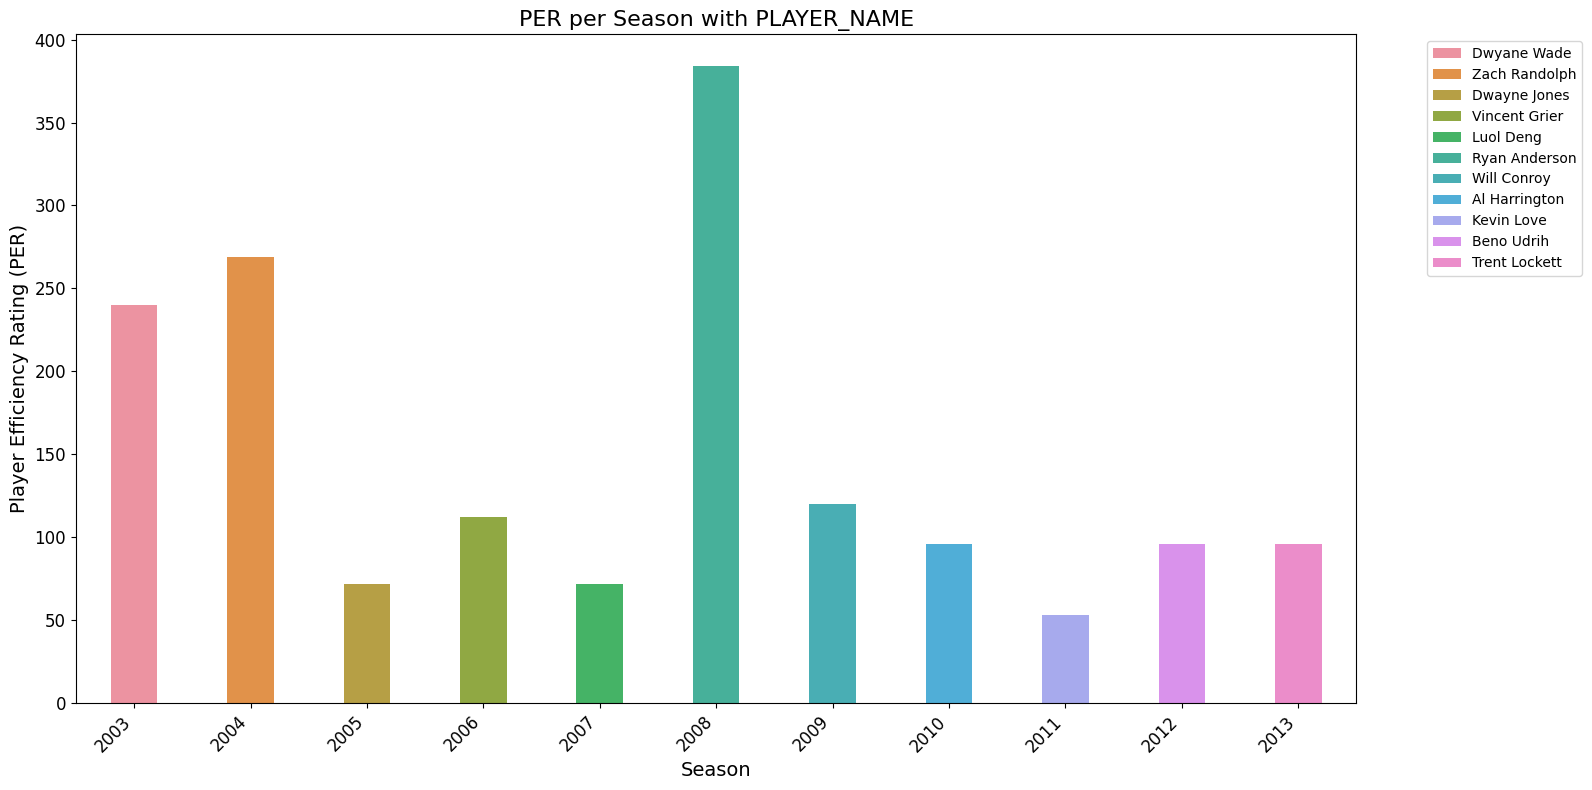

In [11]:
# Set the bar width
bar_width = 0.4


plt.figure(figsize=(16, 8))
sns.barplot(x='SEASON_x', y='PER', hue='PLAYER_NAME', data=subset_highest_per_players, dodge=False, saturation=0.8, width=bar_width)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Player Efficiency Rating (PER)', fontsize=14)
plt.title('PER per Season with PLAYER_NAME', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

# Classification Models

## Logistic Regression

In [12]:

df = pd.read_csv('games.csv')


predictor_columns = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home',  'AST_home', 'REB_home',
                      'HOME_TEAM_WINS']

df = df[predictor_columns]

df['HOME_TEAM_WINS'] = df['HOME_TEAM_WINS'].astype('str')


df = df.dropna()


X = df.drop('HOME_TEAM_WINS', axis=1)
y = df['HOME_TEAM_WINS']
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1042)

# Standardizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(random_state=8899)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Accuracy: 0.76

Confusion Matrix:
[[2202 1075]
 [ 870 3819]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      3277
           1       0.78      0.81      0.80      4689

    accuracy                           0.76      7966
   macro avg       0.75      0.74      0.75      7966
weighted avg       0.75      0.76      0.75      7966



# ROC Curve

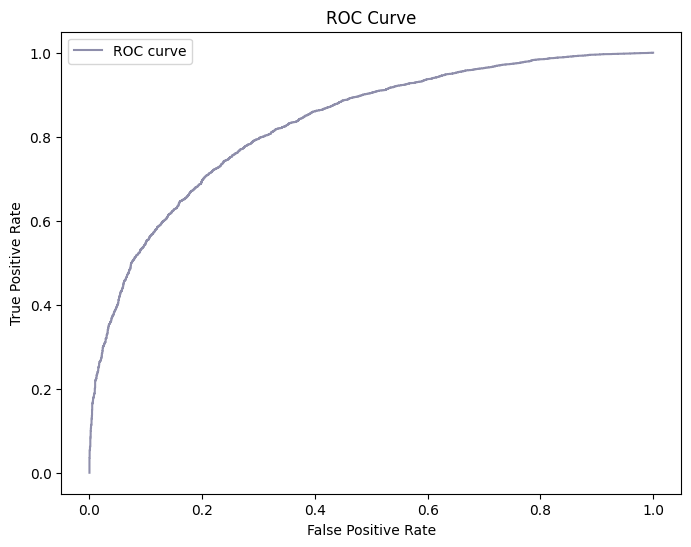

AUC Score: 0.83


In [13]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test.astype(int), y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve', color='#8E8EAB')  # Set the color to #8E8EAB
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#printing AUC score
auc_score = roc_auc_score(y_test.astype(int), y_probs)
print(f'AUC Score: {auc_score:.2f}')

# tuning C parameter

In [14]:
for c_value in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=c_value, random_state=8899)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'C={c_value}, Accuracy: {accuracy:.2f}')

C=0.001, Accuracy: 0.75
C=0.01, Accuracy: 0.75
C=0.1, Accuracy: 0.76
C=1, Accuracy: 0.76
C=10, Accuracy: 0.76
C=100, Accuracy: 0.76


#  Decision Tree

In [15]:
predictor_columns = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home',  'AST_home', 'REB_home',
                     'HOME_TEAM_WINS']


df = df[predictor_columns]


df = df.dropna()

# Separating features (X) and target variable (y)
X = df.drop('HOME_TEAM_WINS', axis=1)
y = df['HOME_TEAM_WINS']

# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1042)

# Standardizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


tree_model = DecisionTreeClassifier(random_state=8899)
tree_model.fit(X_train_scaled, y_train)


y_pred = tree_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Decision Tree Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

Decision Tree Accuracy: 0.67

Confusion Matrix:
[[1994 1283]
 [1326 3363]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      3277
           1       0.72      0.72      0.72      4689

    accuracy                           0.67      7966
   macro avg       0.66      0.66      0.66      7966
weighted avg       0.67      0.67      0.67      7966



# Support Vector Machine

In [16]:


predictor_columns = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']

df = df[predictor_columns]


df = df.dropna()


X = df.drop('HOME_TEAM_WINS', axis=1)
y = df['HOME_TEAM_WINS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1042)

# standardizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


svm_model = SVC(random_state=8899)
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

# Evaluating
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'SVM Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

SVM Accuracy: 0.75

Confusion Matrix:
[[2111 1166]
 [ 786 3903]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      3277
           1       0.77      0.83      0.80      4689

    accuracy                           0.75      7966
   macro avg       0.75      0.74      0.74      7966
weighted avg       0.75      0.75      0.75      7966



# KNN

In [17]:
# Select relevant predictor variables
predictor_columns = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']

# Subset the DataFrame with relevant columns
df = df[predictor_columns]

# Remove rows with missing values
df = df.dropna()

# Separate features (X) and target variable (y)
X = df.drop('HOME_TEAM_WINS', axis=1)
y = df['HOME_TEAM_WINS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1042)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors) as needed
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'KNN Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)

KNN Accuracy: 0.72

Confusion Matrix:
[[2081 1196]
 [1034 3655]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      3277
           1       0.75      0.78      0.77      4689

    accuracy                           0.72      7966
   macro avg       0.71      0.71      0.71      7966
weighted avg       0.72      0.72      0.72      7966

